# Loop state inference for *Fbn2* TAD in mESCs

For this analysis, we use the data from [Gabriele et al (2022)](https://www.science.org/doi/10.1126/science.abn6583). The data analyzed in this notebook are the C36 (wild type) and C65 (control) strains.

In [1]:
data_dire = "../../gabriele_et_al_2023/data"

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import traceHMM.model as trm
from traceHMM.utils import plot as tplt
from traceHMM.utils.func import long_to_tensor, add_predictions_to_df

In [3]:
%reload_ext autoreload
%autoreload 2

### Reproduce the 4DN hackathon results

First, read in both the control and the experimental groups. The `id` column indicates which trace each row belongs to, and `t` records the time point.

In [4]:
path = os.path.join(data_dire, "C65.tagged_set.tsv")
data65 = pd.read_csv(path, sep="\t")
print(f"{path.split("/")[-1]} has {len(pd.unique(data65.id))} trajectories")
print(data65.head().to_string())

path = os.path.join(data_dire, "C36.tagged_set.tsv")
data36 = pd.read_csv(path, sep="\t")
print(f"{path.split("/")[-1]} has {len(pd.unique(data36.id))} trajectories")
print(data36.head().to_string())

C65.tagged_set.tsv has 147 trajectories
   id  t          x          y         z         x2         y2        z2      dist           movie_index
0   0  1  33.384880  28.749708  1.267213  32.952367  29.029923  1.462896  0.551252  2020_09_03_movie1-03
1   0  2  33.377873  28.654452  1.225418  32.798974  28.968542  1.258580  0.659452  2020_09_03_movie1-03
2   0  3  33.347297  28.501661  1.093382  32.748908  28.775660  1.172601  0.662888  2020_09_03_movie1-03
3   0  4  33.410479  28.231071  1.050455  32.805305  28.571315  1.108860  0.696716  2020_09_03_movie1-03
4   0  7  33.661071  28.774886  1.453220  33.162907  28.963981  1.377385  0.538214  2020_09_03_movie1-03
C36.tagged_set.tsv has 491 trajectories
   id   t          x          y         z         x2         y2        z2      dist           movie_index
0   0   6  21.402718  28.628556  5.736118  21.410426  28.615074  5.612181  0.124906  2020_08_31_movie1-03
1   0   7  21.842653  28.646646  5.347591  21.865756  28.661069  5.405542  0.0

Calculate the variance of each state using the variance from the C65 group.

In [5]:
cols = ["x", "y", "z"]
for c in cols:
    for df in [data36, data65]:
        df[f"d{c}"] = df[c] - df[f"{c}2"]
null_cov = data65[["dx", "dy", "dz"]].var(axis=0)
null_cov = np.diag(null_cov)
r = 0.15 # loop state variance is 15% of unloop state
covs = np.stack([null_cov*v for v in np.linspace(r, 1, 3)])
covs

array([[[0.01453355, 0.        , 0.        ],
        [0.        , 0.01322972, 0.        ],
        [0.        , 0.        , 0.01580395]],

       [[0.05571193, 0.        , 0.        ],
        [0.        , 0.05071393, 0.        ],
        [0.        , 0.        , 0.06058182]],

       [[0.09689032, 0.        , 0.        ],
        [0.        , 0.08819814, 0.        ],
        [0.        , 0.        , 0.10535968]]])

Reshape the dataframe to a three dimensional numpy array.

In [6]:
X36 = long_to_tensor(data36, t_col="t", id_col="id", val_cols=["dx", "dy", "dz"])
print("Array shape for C36 (N, T, S):", X36.shape)
X65 = long_to_tensor(data65, t_col="t", id_col="id", val_cols=["dx", "dy", "dz"])
print("Array shape for C65 (N, T, S):", X65.shape)

Array shape for C36 (N, T, S): (491, 365, 3)
Array shape for C65 (N, T, S): (147, 365, 3)


Here, the chain is not allowed to jump directly from unlooped to looped or looped to unlooped. This is achived by setting the corner elements of the transition matrix to 0 while leaving other entries to be negative (negative value -> will be updated in fitting, see more in API Reference).

In [7]:
dist_params = ({"cov":covs[0]}, {"cov":covs[1]}, {"cov":covs[2]})
tm36 = trm.TraceModel(
    X=X36, Pm=np.array([
        [-1, -1,  0],
        [-1, -1, -1],
        [ 0, -1, -1]
    ]),
    dist_params=dist_params,
    dist_type=trm.multivariate_normal,
)
tm36.fit(max_iter=200)

Converged at iteration 90


There is a `convergence` attribute for `TraceModel`, which records the mean absolute difference of the transition matrix between two consecutive iterations. We can plot this difference to see the convergence of the model. In addition, we plot the log-likelihood at each iteration to check the model fit.

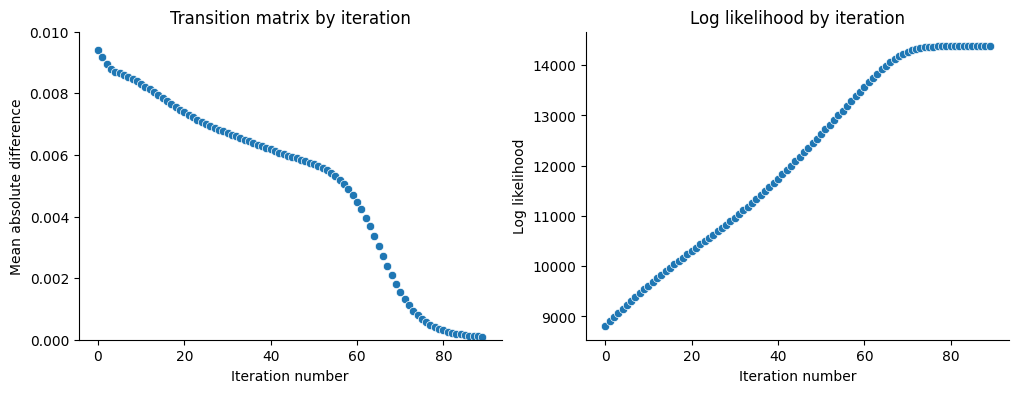

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(tm36.convergence, ax=axes[0])
axes[0].set(
    xlabel="Iteration number", ylabel="Mean absolute difference",
    title="Transition matrix by iteration", ylim=(0, 0.01)
)
sns.scatterplot(tm36.lklhd, ax=axes[1])
axes[1].set(
    xlabel="Iteration number", ylabel="Log likelihood",
    title="Log likelihood by iteration"
)
plt.show()

The fitted transition matrix and its corresponding stationary distribution is shown below:

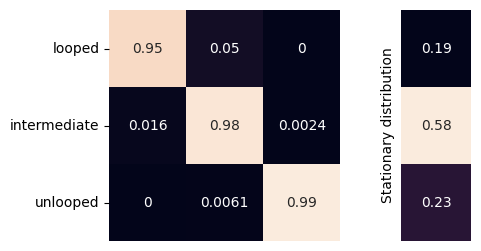

In [9]:
fig = tplt.plot_transition_matrix(tm36.P)

Decode the observed traces with the fitted model shows that the chain spends about 7% time in the looped state.

In [10]:
counts = np.unique(tm36.decode(), return_counts=True)[1]
print(f"C36 Loop fraction: {np.round(counts[0]/sum(counts), 4)*100}%")
counts = np.unique(tm36.decode(X65), return_counts=True)[1]
print(f"C65 Loop fraction: {np.round(counts[0]/sum(counts), 4)*100}%")

C36 Loop fraction: 7.39%
C65 Loop fraction: 4.05%


Below we show some sample traces from C36 and C65, along with their decoded states:

In [11]:
add_predictions_to_df(data36, tm36.decode(), X=X36)
add_predictions_to_df(data65, tm36.decode(X65), X=X65)

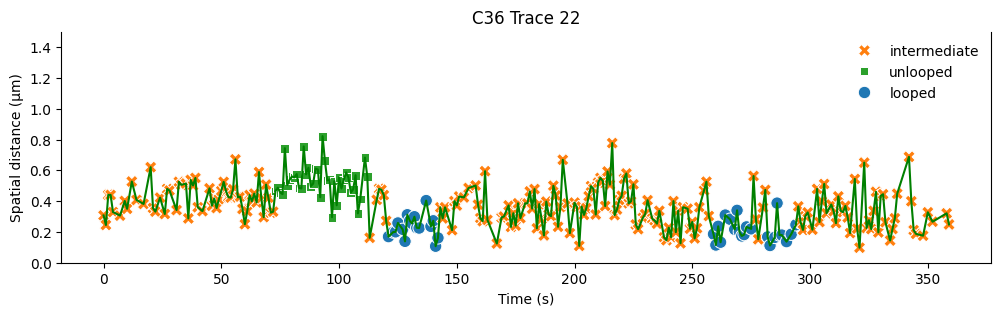

In [12]:
code_book = {0:"looped", 1:"intermediate", 2:"unlooped"}
df = data36[data36["id"]==22]
fig, ax = tplt.plot_trace(df, "t", "dist", "state", code_book)
ax.set(ylim=(0, 1.5), xlabel="Time (s)", ylabel="Spatial distance (µm)", title="C36 Trace 22")
plt.show()

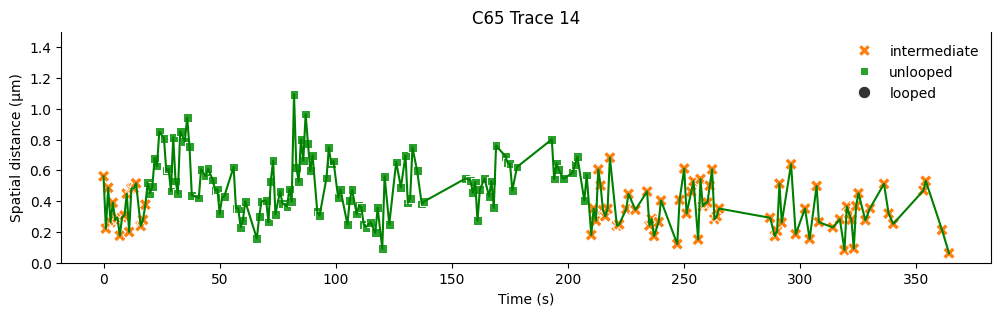

In [13]:
code_book = {0:"looped", 1:"intermediate", 2:"unlooped"}
df = data65[data65["id"]==14]
fig, ax = tplt.plot_trace(df, "t", "dist", "state", code_book)
ax.set(ylim=(0, 1.5), xlabel="Time (s)", ylabel="Spatial distance (µm)", title="C65 Trace 14")
plt.show()

_____

### Fit with localization errors

In [14]:
exp_dist = np.array([0.15, 0.4, 0.6])
var_ls = exp_dist**2/3
dist_params = tuple([{"cov":np.identity(3)*var_ls[i]} for i in range(3)])
tm = trm.TraceModel(
    X=X36, Pm=np.array([
        [-1, -1,  0],
        [-1, -1, -1],
        [ 0, -1, -1]
    ]),
    dist_params=dist_params,
    dist_type=trm.multivariate_normal,
    update_dist_params=["err"]
)
tm.fit(600)

Converged at iteration 64


In [15]:
tm.loc_err

array([0.        , 0.        , 0.10753339])

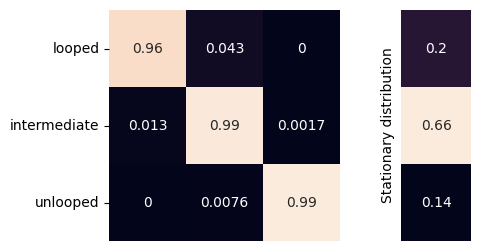

In [16]:
fig = tplt.plot_transition_matrix(tm.P)

In [17]:
counts = np.unique(tm.decode(), return_counts=True)[1]
print(f"C36 Loop fraction: {np.round(counts[0]/sum(counts), 4)*100}%")
counts = np.unique(tm.decode(X65), return_counts=True)[1]
print(f"C65 Loop fraction: {np.round(counts[0]/sum(counts), 4)*100}%")

C36 Loop fraction: 8.27%
C65 Loop fraction: 4.19%
